In [1]:
import numpy as np
import flopy

##### Create Flopy model object

In [14]:
modelname = "tutorial01_mf"
mf        = flopy.modflow.Modflow(modelname, exe_name='../basinModel/mf2005')

### 2. Discretization
##### 2.1 Define model domain and create MODFLOW grid

In [7]:
Lx = 1000
Ly = 1000
ztop = 0
zbot = -50
nlay = 1
nrow = 10
ncol = 10
delr = Lx / ncol
delc = Ly / nrow
delv = (ztop-zbot) / nlay
botm = np.linspace(ztop, zbot, nlay + 1)

##### 2.2 Create Flopy discretization object (DIS)

In [5]:
dis = flopy.modflow.ModflowDis(
    mf, nlay, nrow, ncol, delr=delr, delc=delc, top=ztop, botm=botm[1:]
)

### 3. Basic Package (BAS)
##### 3.1 Assign initial head values

In [9]:
#==== Set first and last column to type 1 boundaries ==========================
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:,:,0]  = -1
ibound[:,:,-1] = -1
#==== Assign values to constant head boundaries================================
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:,:,0]  = 10
strt[:,:,-1] = 0

bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

### 4. Layer-Property Flow Package (LPF)
##### 4.1 Assign hydraulic conductivity values for cells

In [10]:
#==== Assign values to vertical and horizontal hydraulic conductivities ======
hk = 10; vk = 10

lpf = flopy.modflow.ModflowLpf(mf, hk=hk, vka=vk, ipakcb=53)

*Note: because we did not specify a value for **laytyp**, Flopy will use the default value of 0, which means this model will be confined.*

### 5. Output Control (OC)
##### 5.1 Use default OC settings

In [11]:
#==== Use stress period dictionary to set what output is saved ===============
spd = {(0,0): ['print head', 'print budget', 'save head', 'save budget']}

oc  = flopy.modflow.ModflowOc(mf, stress_period_data=spd, compact=True)

*Note: The tuple (0,0) means that stress peopd 1 and time step 1 for MODFLOW will have output saved. Head and budgets will be printed, and head and budget information will be saved.*

### 6. Preconditioned Conjugate Gradient Package (PCG)
##### 6.1 Use default PCG settings 

In [12]:
pcg = flopy.modflow.ModflowPcg(mf)

### 7. Write MODFLOW input data files
##### 7.1 Need to command this step

In [13]:
mf.write_input()

### 8. Run the model
##### 8.1 Specify the name of the executable program and run model

In [15]:
success, buff = mf.run_model()
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: ../basinModel/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: tutorial01_mf.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/05/11 15:48:12

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/05/11 15:48:12
 Elapsed run time:  0.084 Seconds

  Normal termination of simulation


## Part 2
### 2.1 Post-processing results

In [16]:
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

##### 2.1.1 Extract the heads

In [17]:
#==== Specify name of the heads output file ==================================
hds  = bf.HeadFile(modelname + ".hds")
#==== Extract heads data and assign to object ================================
head = hds.get_data(totim=1.0)

##### 2.1.2 Contour the heads

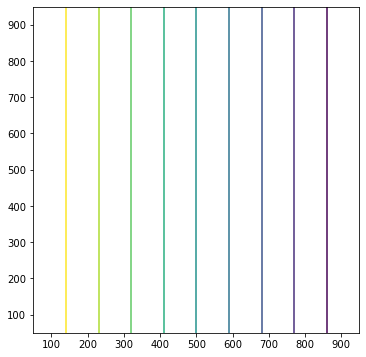

In [18]:
extent = (delr/2.0, Lx - delr/2.0, Ly - delc/2.0, delc/2.0)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1, aspect='equal')
ax.contour(head[0,:,:], levels=np.arange(1,10,1), extent=extent)